# SGD Performance Benchmarks

This notebook benchmarks the performance of SGD-based approaches for permutation weighting against standard batch methods. We'll look at:

1. Training time
2. Memory usage
3. Estimation accuracy

as a function of dataset size.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from permutation_weighting import PW
import time
import psutil
import gc
import os

# For tracking memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # in MB

# Set plotting style
sns.set_style("whitegrid")
np.random.seed(42)

## Generate Data of Different Sizes

We'll use the Kang-Schafer data generation process to create datasets of different sizes.

In [2]:
def generate_kang_schafer_data(n, misspecified=False):
    # Generate covariates
    X = np.random.normal(size=(n, 4))
    
    # Generate propensity scores
    propensity = 1 / (1 + np.exp(X[:, 0] - 0.5 * X[:, 1] + 0.25 * X[:, 2] + 0.1 * X[:, 3]))
    
    # Generate treatment
    A = np.random.binomial(1, propensity, size=n)
    
    # Generate outcome (true effect is 0)
    Y = 210 + 27.4 * X[:, 0] + 13.7 * X[:, 1] + 13.7 * X[:, 2] + 13.7 * X[:, 3] + np.random.normal(size=n)
    
    # Apply transformation if misspecified
    if misspecified:
        X = np.column_stack([
            np.exp(X[:, 0] / 2),
            X[:, 1] * (1 + np.exp(X[:, 0])) ** (-1) + 10,
            (X[:, 0] * X[:, 2] / 25 + 0.6) ** 3,
            (X[:, 1] + X[:, 3] + 20) ** 2
        ])
    
    return A, X, Y

## Benchmark Functions

Now, let's define functions to measure training time, memory usage, and estimation accuracy.

In [3]:
def benchmark_performance(n, classifier, use_sgd, batch_size=None, num_replicates=10):
    # Generate data
    A, X, Y = generate_kang_schafer_data(n, misspecified=True)
    
    # Measure memory before
    mem_before = get_memory_usage()
    
    # Measure training time
    start_time = time.time()
    model = PW(A, X, classifier=classifier, num_replicates=num_replicates, 
              use_sgd=use_sgd, batch_size=batch_size)
    training_time = time.time() - start_time
    
    # Measure memory after
    mem_after = get_memory_usage()
    memory_used = mem_after - mem_before
    
    # Handle possible NaN values in weights
    weights = model['weights']
    weights = np.nan_to_num(weights, nan=1.0)  # Replace NaNs with 1.0
    
    # Calculate ATE
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(A.reshape(-1, 1), Y, sample_weight=weights)
    ate = lr.coef_[0]
    
    # Calculate balance metrics
    mse = model['train']['MSEEvaluator']
    logloss = model['train']['LogLossEvaluator']
    
    # Free memory
    del model
    gc.collect()
    
    return {
        'n': n,
        'classifier': classifier,
        'use_sgd': use_sgd,
        'batch_size': batch_size,
        'training_time': training_time,
        'memory_used': memory_used,
        'ate': ate,
        'mse': mse,
        'logloss': logloss
    }

## Run Benchmarks

Let's run benchmarks for different dataset sizes and methods.

In [4]:
# Dataset sizes to test
sizes = [1000, 5000, 10000]
#sizes = [1000, 5000]

# Methods to benchmark
methods = [
    {'classifier': 'logit', 'use_sgd': False, 'batch_size': None, 'label': 'Logistic (Batch)'},
    {'classifier': 'logit', 'use_sgd': True, 'batch_size': None, 'label': 'Logistic (SGD)'},
    {'classifier': 'logit', 'use_sgd': True, 'batch_size': 128, 'label': 'Logistic (Minibatch-128)'},
    {'classifier': 'logit', 'use_sgd': True, 'batch_size': 512, 'label': 'Logistic (Minibatch-512)'},
    {'classifier': 'neural_net', 'use_sgd': True, 'batch_size': None, 'label': 'Neural Net (SGD)'},
    {'classifier': 'neural_net', 'use_sgd': True, 'batch_size': 128, 'label': 'Neural Net (SGD)(Minibatch-128)'}
    #{'classifier': 'neural_net', 'use_sgd': True, 'batch_size': 512, 'label': 'Neural Net (SGD)(Minibatch-512)'}
]

# Run benchmarks
results = []

for n in sizes:
    for method in methods:
        # Skip batch methods for very large datasets to avoid memory issues
        if n > 10000 and not method['use_sgd']:
            continue
            
        print(f"Running benchmark: n={n}, method={method['label']}")
        result = benchmark_performance(
            n=n, 
            classifier=method['classifier'], 
            use_sgd=method['use_sgd'], 
            batch_size=method['batch_size']
        )
        result['label'] = method['label']
        results.append(result)
        
# Convert to DataFrame
results_df = pd.DataFrame(results)

Running benchmark: n=1000, method=Logistic (Batch)
Running benchmark: n=1000, method=Logistic (SGD)
Running benchmark: n=1000, method=Logistic (Minibatch-128)
Running benchmark: n=1000, method=Logistic (Minibatch-512)
Running benchmark: n=1000, method=Neural Net (SGD)
Running benchmark: n=1000, method=Neural Net (SGD)(Minibatch-128)


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 

Running benchmark: n=5000, method=Logistic (Batch)


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Running benchmark: n=5000, method=Logistic (SGD)
Running benchmark: n=5000, method=Logistic (Minibatch-128)
Running benchmark: n=5000, method=Logistic (Minibatch-512)
Running benchmark: n=5000, method=Neural Net (SGD)
Running benchmark: n=5000, method=Neural Net (SGD)(Minibatch-128)


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 

Running benchmark: n=10000, method=Logistic (Batch)
Running benchmark: n=10000, method=Logistic (SGD)
Running benchmark: n=10000, method=Logistic (Minibatch-128)
Running benchmark: n=10000, method=Logistic (Minibatch-512)
Running benchmark: n=10000, method=Neural Net (SGD)
Running benchmark: n=10000, method=Neural Net (SGD)(Minibatch-128)


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 

## Visualize Results

Let's visualize the benchmark results.

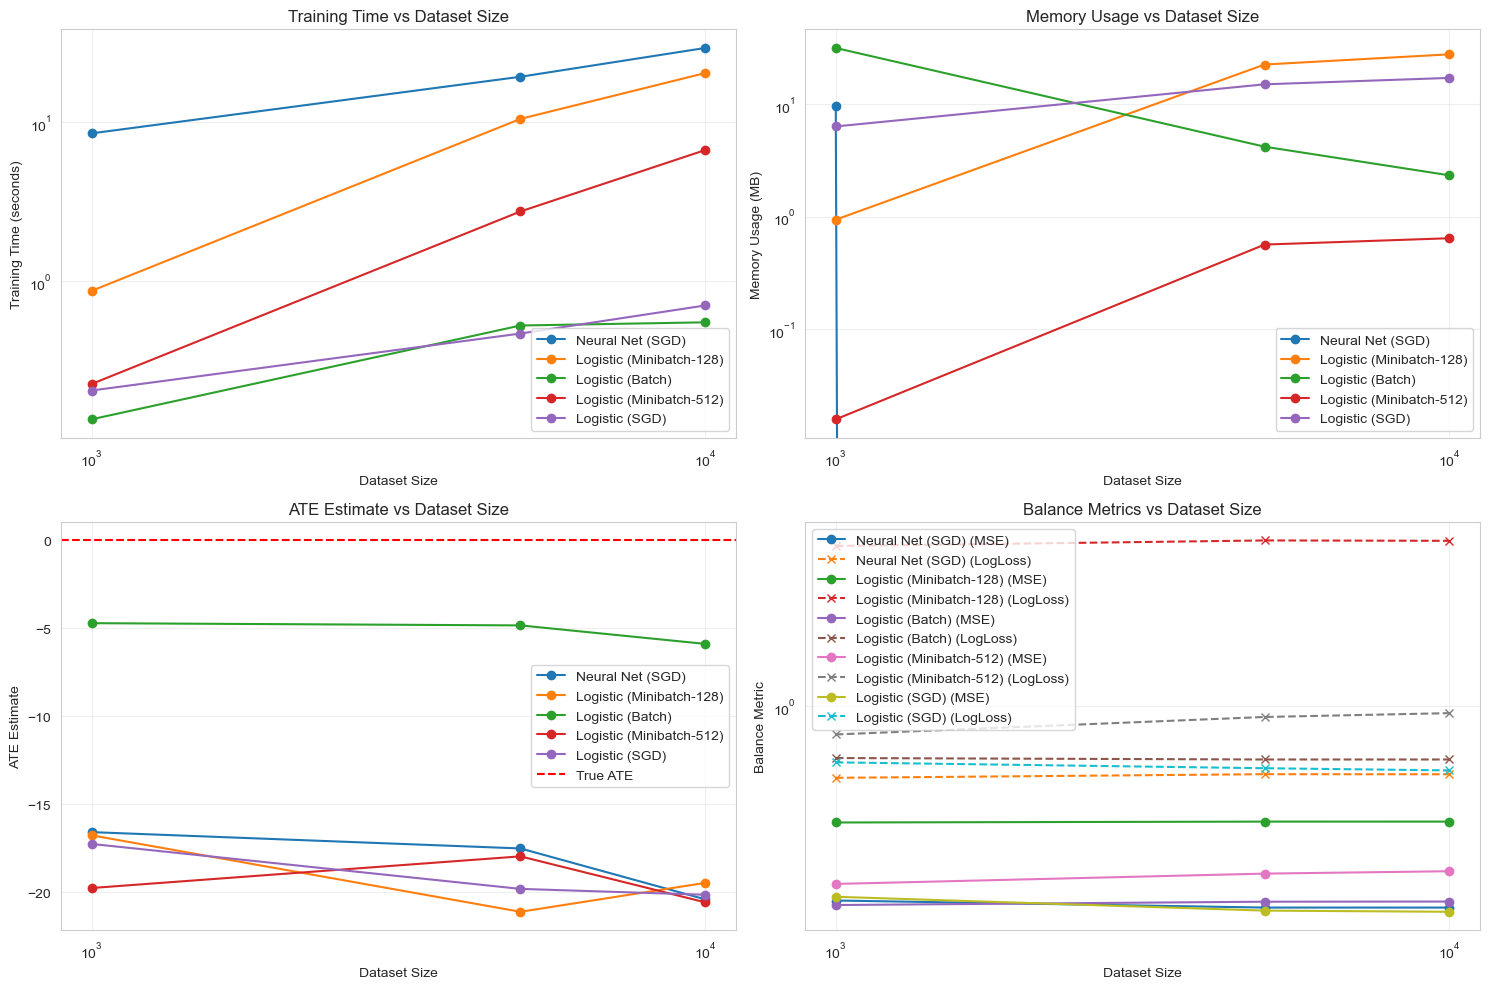

In [15]:
plt.figure(figsize=(15, 10))

# Plot training time
plt.subplot(2, 2, 1)
for method in set(results_df['label']):
    method_df = results_df[results_df['label'] == method]
    plt.plot(method_df['n'], method_df['training_time'], marker='o', label=method)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Dataset Size')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs Dataset Size')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot memory usage
plt.subplot(2, 2, 2)
for method in set(results_df['label']):
    method_df = results_df[results_df['label'] == method]
    plt.plot(method_df['n'], method_df['memory_used'], marker='o', label=method)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Dataset Size')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage vs Dataset Size')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot ATE
plt.subplot(2, 2, 3)
for method in set(results_df['label']):
    method_df = results_df[results_df['label'] == method]
    plt.plot(method_df['n'], method_df['ate'], marker='o', label=method)
plt.axhline(y=0, color='r', linestyle='--', label='True ATE')
plt.xscale('log')
plt.xlabel('Dataset Size')
plt.ylabel('ATE Estimate')
plt.title('ATE Estimate vs Dataset Size')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot balance metrics
plt.subplot(2, 2, 4)
for method in set(results_df['label']):
    method_df = results_df[results_df['label'] == method]
    plt.plot(method_df['n'], method_df['mse'], marker='o', linestyle='-', label=f"{method} (MSE)")
    plt.plot(method_df['n'], method_df['logloss'], marker='x', linestyle='--', label=f"{method} (LogLoss)")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Dataset Size')
plt.ylabel('Balance Metric')
plt.title('Balance Metrics vs Dataset Size')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

## Training Time vs Accuracy Tradeoff

Let's look at the tradeoff between training time and estimation accuracy.

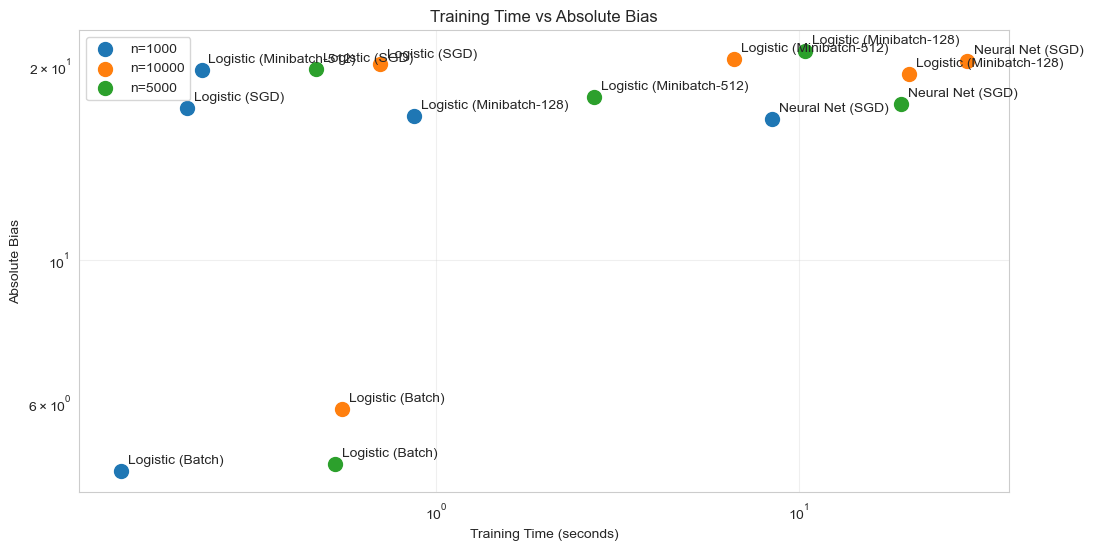

In [16]:
plt.figure(figsize=(12, 6))

# Calculate absolute bias
results_df['abs_bias'] = np.abs(results_df['ate'] - 0)

for n in set(results_df['n']):
    subset = results_df[results_df['n'] == n]
    plt.scatter(subset['training_time'], subset['abs_bias'], s=100, label=f'n={n}')
    
    # Add method labels
    for i, row in subset.iterrows():
        plt.annotate(row['label'], 
                     (row['training_time'], row['abs_bias']),
                     xytext=(5, 5), 
                     textcoords='offset points')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Training Time (seconds)')
plt.ylabel('Absolute Bias')
plt.title('Training Time vs Absolute Bias')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Memory Usage vs Accuracy Tradeoff

Let's look at the tradeoff between memory usage and estimation accuracy.

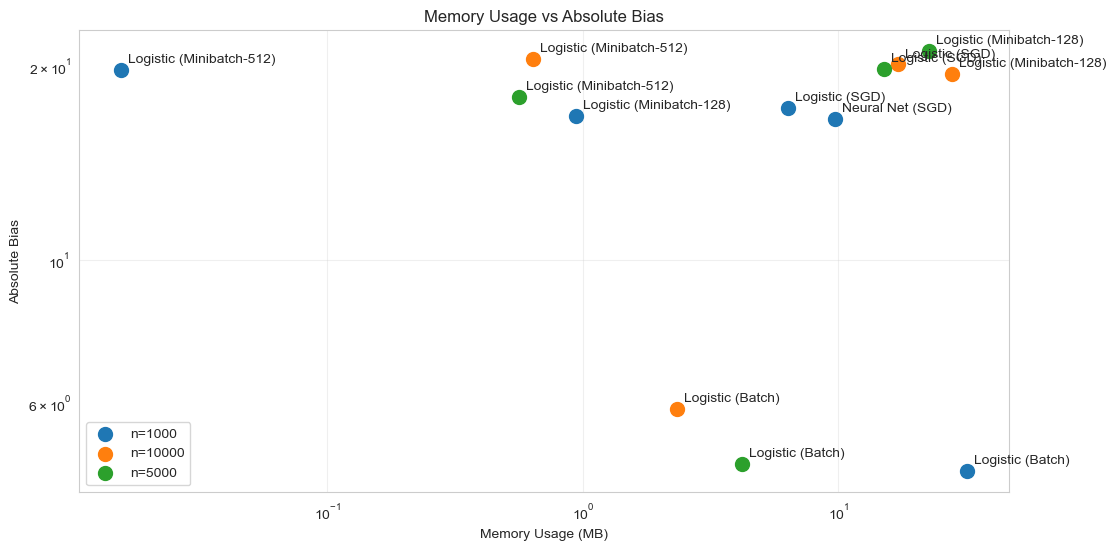

In [17]:
plt.figure(figsize=(12, 6))

for n in set(results_df['n']):
    subset = results_df[results_df['n'] == n]
    plt.scatter(subset['memory_used'], subset['abs_bias'], s=100, label=f'n={n}')
    
    # Add method labels
    for i, row in subset.iterrows():
        plt.annotate(row['label'], 
                     (row['memory_used'], row['abs_bias']),
                     xytext=(5, 5), 
                     textcoords='offset points')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Memory Usage (MB)')
plt.ylabel('Absolute Bias')
plt.title('Memory Usage vs Absolute Bias')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()